# Redução de Dimensionalidade (DimRed)

- Banco de dados -> https://archive.ics.uci.edu/dataset/42/glass+identification

O objetivo era determinar se um vidro correspondia ao tipo "float" (vidro plano fabricado por flutuação) ou não.

A motivação principal do estudo está relacionada à investigação forense, uma vez que fragmentos de vidro encontrados em cenas de crime podem servir como evidência, desde que corretamente identificados.

O conjunto de dados é composto por 214 amostras de vidro, cada uma descrita por 10 atributos físico-químicos:

- ID: Identificador da amostra (1 a 214)

- RI: Índice de refração

- Na: Teor de sódio (Na₂O) – % em peso

- Mg: Magnésio (MgO) – % em peso

- Al: Alumínio (Al₂O₃) – % em peso

- Si: Silício (SiO₂) – % em peso

- K: Potássio (K₂O) – % em peso

- Ca: Cálcio (CaO) – % em peso

- Ba: Bário (BaO) – % em peso

- Fe: Ferro (Fe₂O₃) – % em peso

O atributo alvo representa o tipo de vidro classificado em sete categorias:

- Janelas de edifícios - float processado

- Janelas de edifícios - não float

- Janelas de veículos - float processado

- Janelas de veículos - não float (ausente no conjunto)

- Recipientes

- Utensílios de mesa

- Faróis

In [ ]:
# Instalando o R
R.version.string
# Isso instala o pacote do sistema GSL necessário para o R
system("apt-get update")
system("apt-get install -y libgsl-dev libxml2-dev libssl-dev libcurl4-openssl-dev libfftw3-dev")

[1] "R version 4.5.0 (2025-04-11)"

In [ ]:
install.packages(c("dimRed", "RANN", "Rtsne", "fastICA", "umap", "diffusionMap", "kernlab"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘CVST’, ‘RcppTOML’, ‘here’, ‘png’, ‘RcppEigen’, ‘DRR’, ‘reticulate’, ‘RSpectra’, ‘scatterplot3d’, ‘igraph’




In [ ]:
install.packages("MVN")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rbibutils’, ‘cowplot’, ‘Deriv’, ‘microbenchmark’, ‘Rdpack’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘mnormt’, ‘GPArotation’, ‘gsl’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘nortest’, ‘psych’, ‘energy’, ‘car’




In [ ]:
# Lista completa de pacotes necessários
all_packages <- c(
  "moments", "reshape2", "ggplot2", "corrplot", "dimRed", "modeest", "coRanking",
  "MVN", "isotree", "fastICA", "Rtsne", "umap", "RANN", "diffusionMap", "gsl",
  "vegan", "kernlab"
)


# Função para instalar se não estiver instalado
install_if_missing <- function(pkg) {
  if (!requireNamespace(pkg, quietly = TRUE)) {
    message("Instalando pacote: ", pkg)
    tryCatch({
      install.packages(pkg, dependencies = TRUE)
    }, warning = function(w) {
      message("Aviso ao instalar ", pkg, ": ", conditionMessage(w))
    }, error = function(e) {
      message("Erro ao instalar ", pkg, ": ", conditionMessage(e))
    })
  }
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}

# Instalar e carregar todos os pacotes
invisible(lapply(all_packages, install_if_missing))

Registered S3 method overwritten by 'psych':
  method         from  
  plot.residuals rmutil

Instalando pacote: isotree

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘gplots’, ‘Rcereal’, ‘visNetwork’, ‘ROCR’, ‘svglite’, ‘RhpcBLASctl’, ‘outliertree’, ‘DiagrammeR’, ‘mlbench’, ‘MLmetrics’, ‘kableExtra’




In [ ]:
# Pacotes
library(moments)
library(reshape2)
library(ggplot2)
library(corrplot)
library(dimRed)
library(modeest)
library(coRanking)
library(MVN)
library(isotree)
required_packages <- c("dimRed", "RSpectra", "igraph", "RANN", "ggplot2",
                       "tidyr", "scales", "kernlab", "factoextra", "pcaL1", "coRanking", "dplyr", "reshape2", "moments", "GGally", "MVN", "corrplot")

In [ ]:
# Listar funções e métodos disponíveis no namespace de dimRed
all_functions <- ls("package:dimRed")

# Exibir todas as funções e objetos disponíveis
cat("Todas as funções e objetos disponíveis em dimRed:\n")
print(all_functions)

# Listar todos os métodos de redução de dimensionalidade disponíveis no pacote dimRed
all_methods <- dimRed::dimRedMethodList()

# Exibir todos os métodos de redução de dimensionalidade disponíveis
cat("Todos os métodos de redução de dimensionalidade disponíveis em dimRed:\n")
print(all_methods)

Todas as funções e objetos disponíveis em dimRed:
 [1] "as.data.frame"          "as.dimRedData"          "AUC_lnK_R_NX"          
 [4] "cophenetic_correlation" "dataSetList"            "DiffusionMaps"         
 [7] "dimRedData"             "dimRedMethodList"       "dimRedQualityList"     
[10] "dimRedResult"           "distance_correlation"   "DrL"                   
[13] "DRR"                    "embed"                  "FastICA"               
[16] "FruchtermanReingold"    "getData"                "getDimRedData"         
[19] "getMeta"                "getNDim"                "getOrgData"            
[22] "getOtherData"           "getPars"                "getRotationMatrix"     
[25] "HLLE"                   "installSuggests"        "inverse"               
[28] "Isomap"                 "KamadaKawai"            "kPCA"                  
[31] "LCMC"                   "loadDataSet"            "maximize_correlation"  
[34] "MDS"                    "mean_R_NX"              "mixColor1Ramps

In [ ]:
# Carregar o Dataset
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data"
glass_data <- read.csv(url, header = FALSE)
colnames(glass_data) <- c("ID", "RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "Type")
print(head(glass_data))
data <- glass_data[, -c(1)]  # Remover coluna ID
print(head(data))

  ID      RI    Na   Mg   Al    Si    K   Ca Ba   Fe Type
1  1 1.52101 13.64 4.49 1.10 71.78 0.06 8.75  0 0.00    1
2  2 1.51761 13.89 3.60 1.36 72.73 0.48 7.83  0 0.00    1
3  3 1.51618 13.53 3.55 1.54 72.99 0.39 7.78  0 0.00    1
4  4 1.51766 13.21 3.69 1.29 72.61 0.57 8.22  0 0.00    1
5  5 1.51742 13.27 3.62 1.24 73.08 0.55 8.07  0 0.00    1
6  6 1.51596 12.79 3.61 1.62 72.97 0.64 8.07  0 0.26    1
       RI    Na   Mg   Al    Si    K   Ca Ba   Fe Type
1 1.52101 13.64 4.49 1.10 71.78 0.06 8.75  0 0.00    1
2 1.51761 13.89 3.60 1.36 72.73 0.48 7.83  0 0.00    1
3 1.51618 13.53 3.55 1.54 72.99 0.39 7.78  0 0.00    1
4 1.51766 13.21 3.69 1.29 72.61 0.57 8.22  0 0.00    1
5 1.51742 13.27 3.62 1.24 73.08 0.55 8.07  0 0.00    1
6 1.51596 12.79 3.61 1.62 72.97 0.64 8.07  0 0.26    1


In [ ]:
# Contar o número de tipos únicos de vidro no dataset
unique_types <- unique(glass_data$Type) # Extrai os valores únicos presentes na coluna Type, correspondendo aos tipos de vidro.
num_types <- length(unique_types) #Conta o número de valores únicos, indicando quantos tipos de vidro diferentes existem.

# Exibir o número de tipos de vidro e as categorias presentes
cat("Número de tipos de vidro:", num_types, "\n")
cat("Tipos de vidro:", unique_types, "\n")

Número de tipos de vidro: 6 
Tipos de vidro: 1 2 3 5 6 7 


In [ ]:
# Verificar o balanceamento da variável alvo (Type)
class_counts <- table(glass_data$Type)

# Exibir os resultados
print(class_counts)


 1  2  3  5  6  7 
70 76 17 13  9 29 


# Análise Exploratória de Dados (EDA)

In [ ]:
# Função para calcular estatísticas descritivas
calcular_estatisticas <- function(df) {
  for (col in colnames(df)) {
    cat("\n📊 Variável:", col, "\n")
    media <- mean(df[[col]])
    mediana <- median(df[[col]])
    moda <- mfv(df[[col]])  # Moda com função do pacote modeest
    desvio_padrao <- sd(df[[col]])
    coef_var <- (desvio_padrao / media) * 100

    cat("Média:", round(media, 3), "\n")
    cat("Mediana:", round(mediana, 3), "\n")
    cat("Moda:", paste(round(moda, 3), collapse = ", "), "\n")
    cat("Desvio padrão:", round(desvio_padrao, 3), "\n")
    cat("Coeficiente de variação (%):", round(coef_var, 2), "\n")
  }
}

# Aplicar a função no dataset
calcular_estatisticas(data)


📊 Variável: RI 
Média: 1.518 
Mediana: 1.518 
Moda: 1.516, 1.516, 1.522 
Desvio padrão: 0.003 
Coeficiente de variação (%): 0.2 

📊 Variável: Na 
Média: 13.408 
Mediana: 13.3 
Moda: 13, 13.02, 13.21 
Desvio padrão: 0.817 
Coeficiente de variação (%): 6.09 

📊 Variável: Mg 
Média: 2.685 
Mediana: 3.48 
Moda: 0 
Desvio padrão: 1.442 
Coeficiente de variação (%): 53.73 

📊 Variável: Al 
Média: 1.445 
Mediana: 1.36 
Moda: 1.54 
Desvio padrão: 0.499 
Coeficiente de variação (%): 34.55 

📊 Variável: Si 
Média: 72.651 
Mediana: 72.79 
Moda: 72.86, 72.99, 73.1, 73.11, 73.28 
Desvio padrão: 0.775 
Coeficiente de variação (%): 1.07 

📊 Variável: K 
Média: 0.497 
Mediana: 0.555 
Moda: 0 
Desvio padrão: 0.652 
Coeficiente de variação (%): 131.21 

📊 Variável: Ca 
Média: 8.957 
Mediana: 8.6 
Moda: 8.03, 8.43 
Desvio padrão: 1.423 
Coeficiente de variação (%): 15.89 

📊 Variável: Ba 
Média: 0.175 
Mediana: 0 
Moda: 0 
Desvio padrão: 0.497 
Coeficiente de variação (%): 284.05 

📊 Variável: Fe 
Média

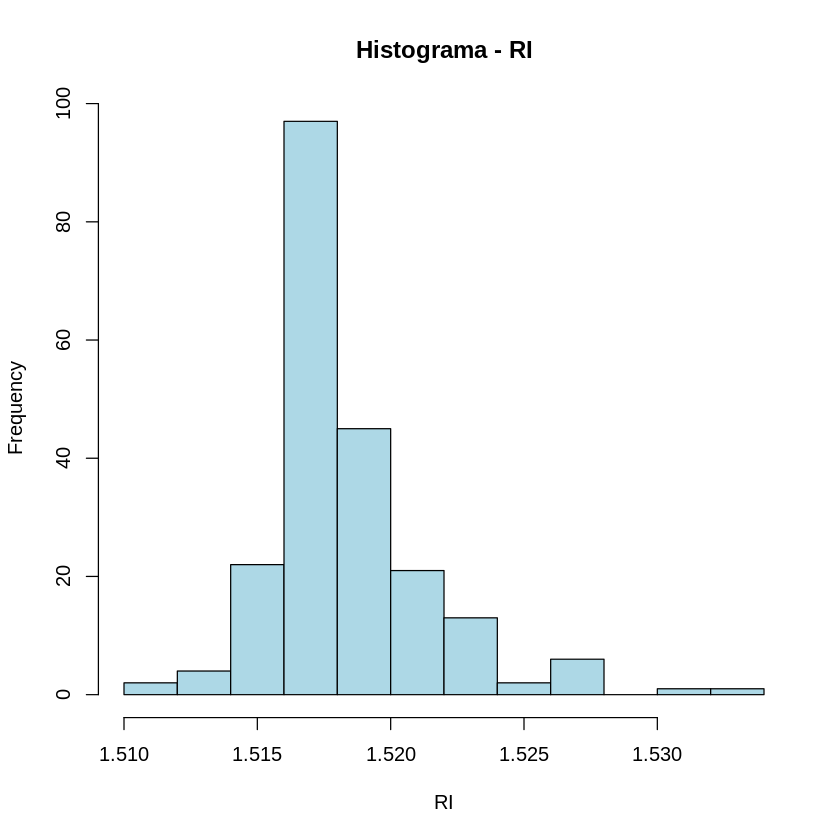

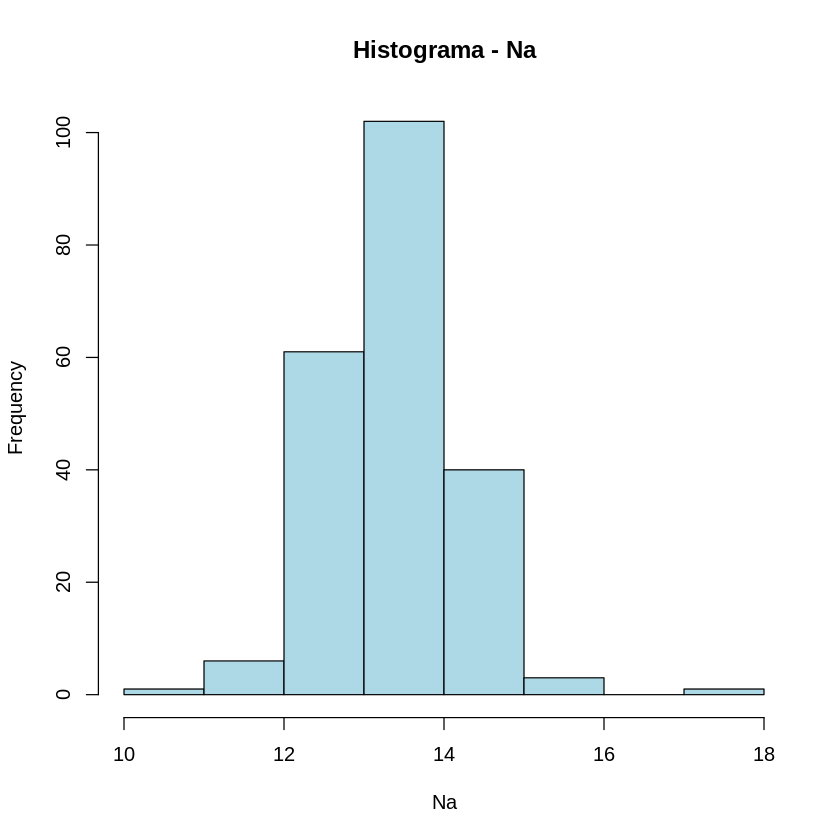

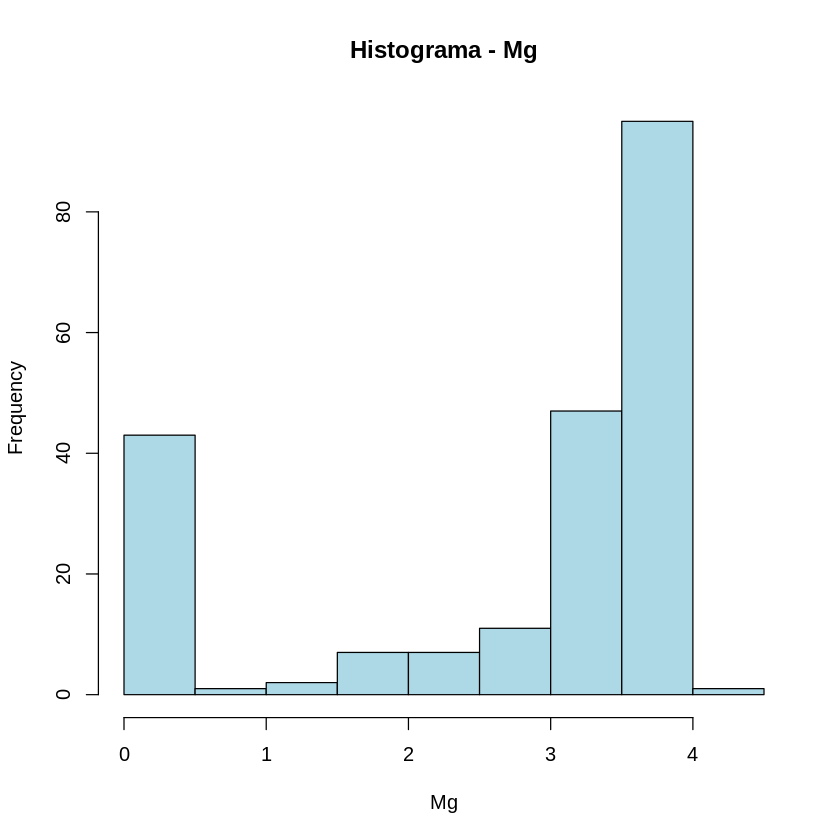

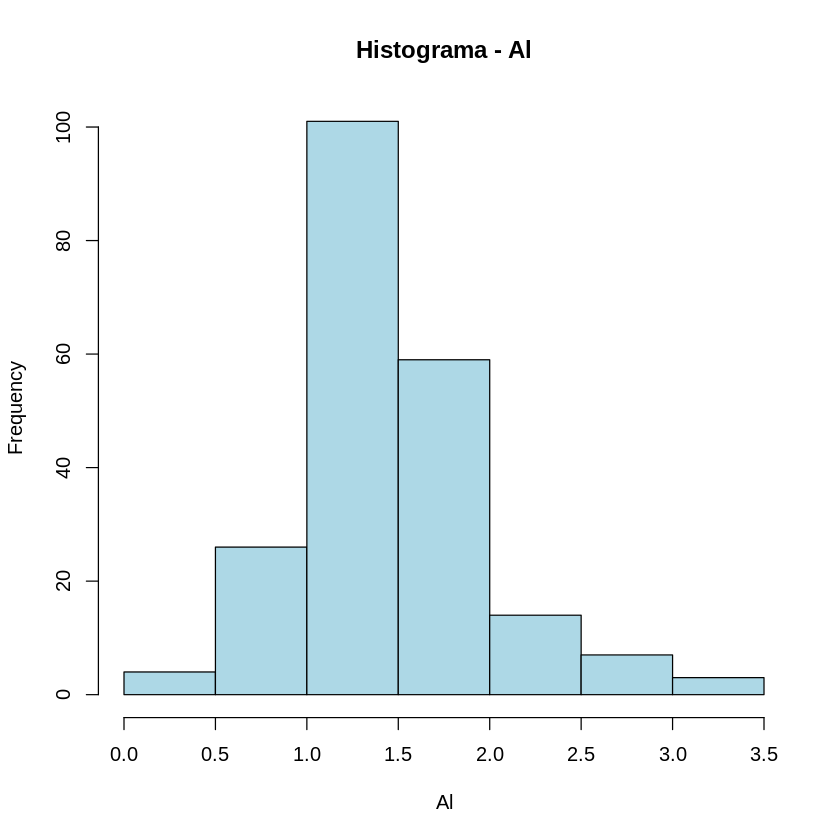

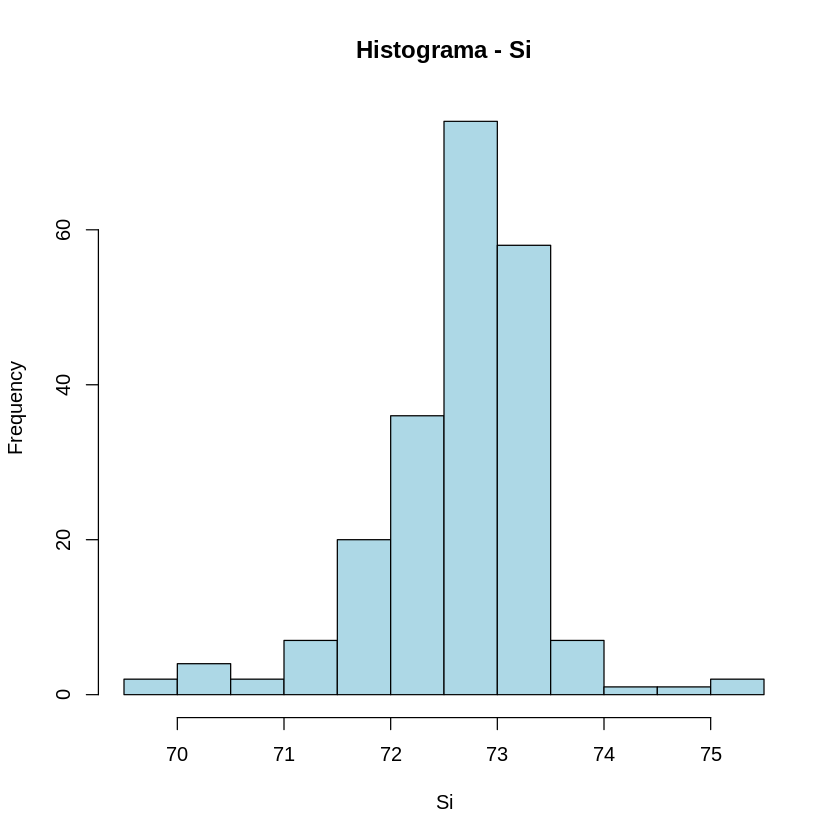

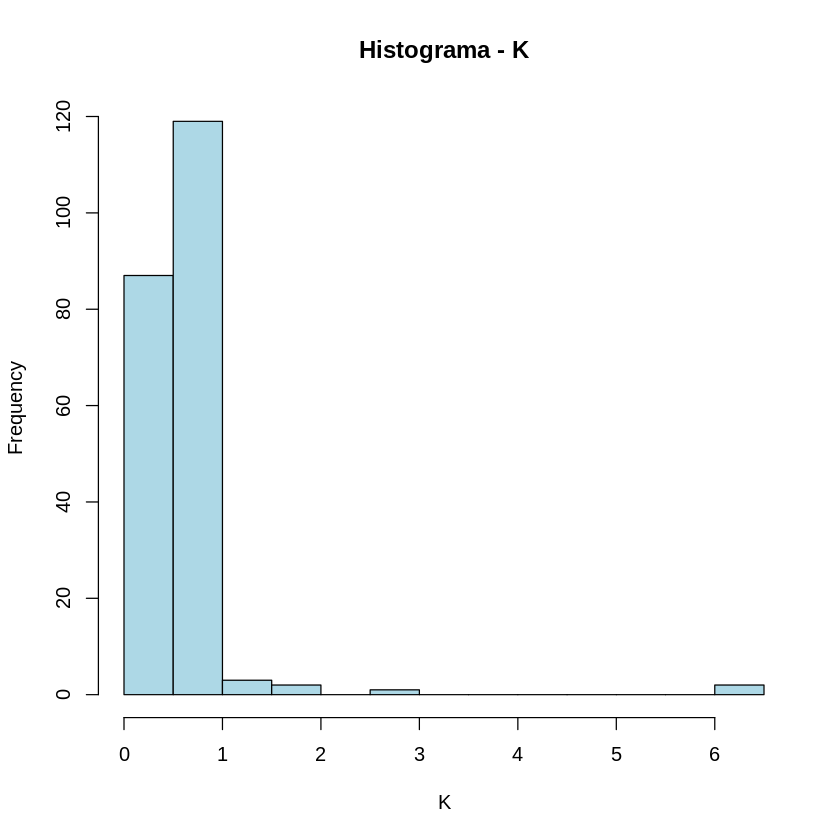

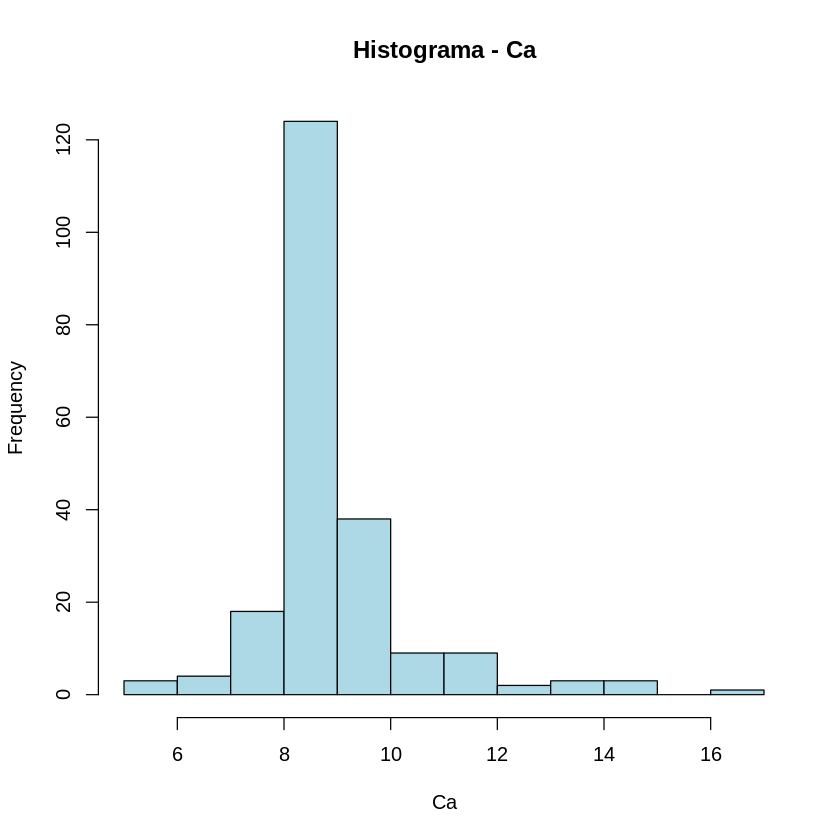

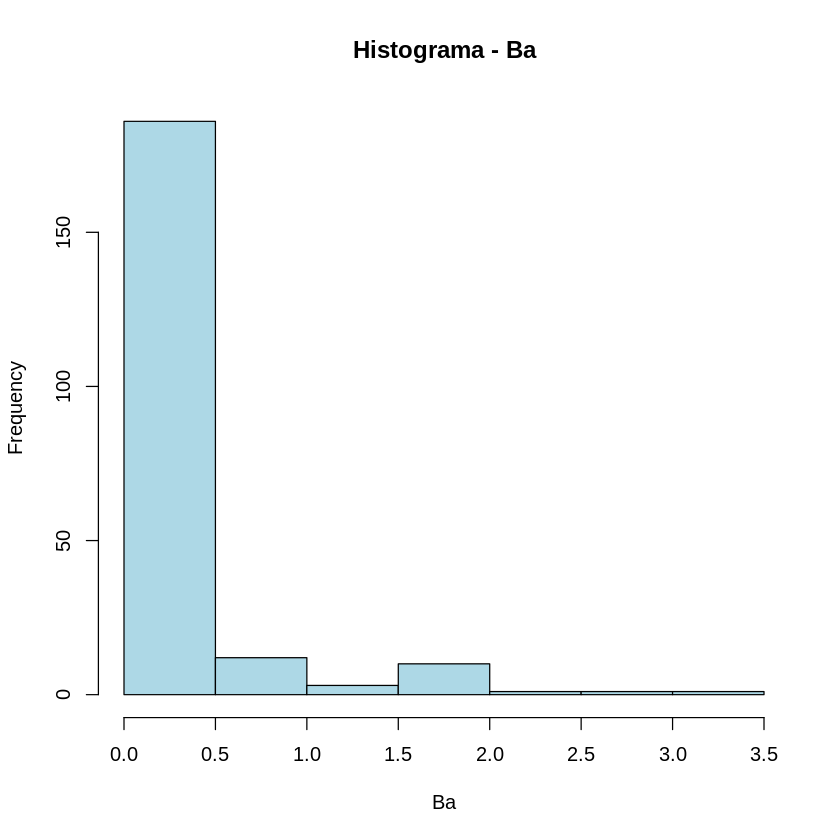

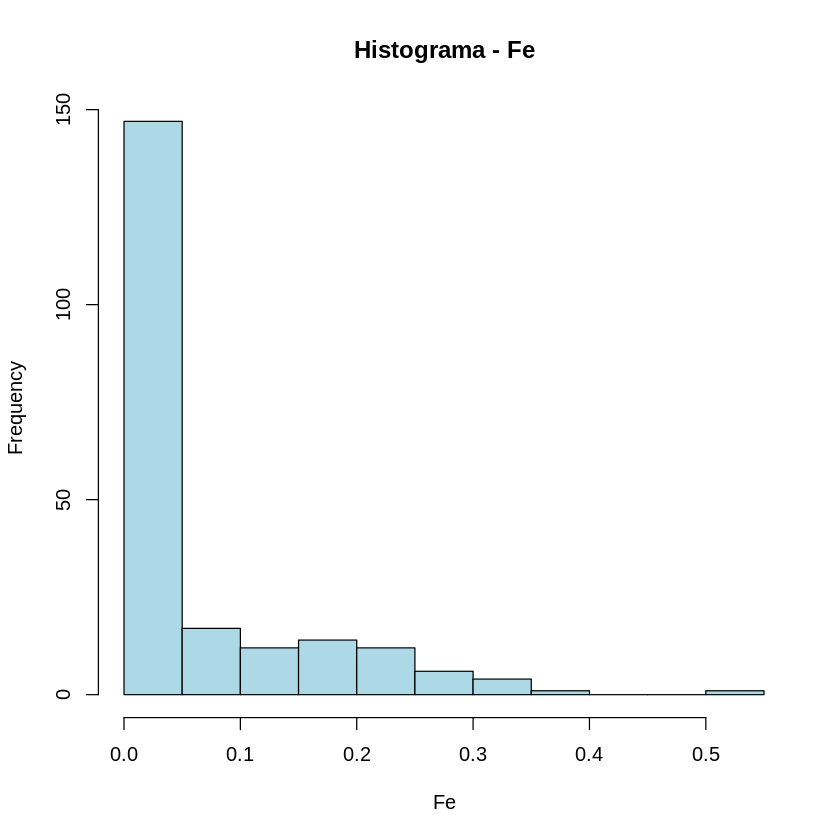

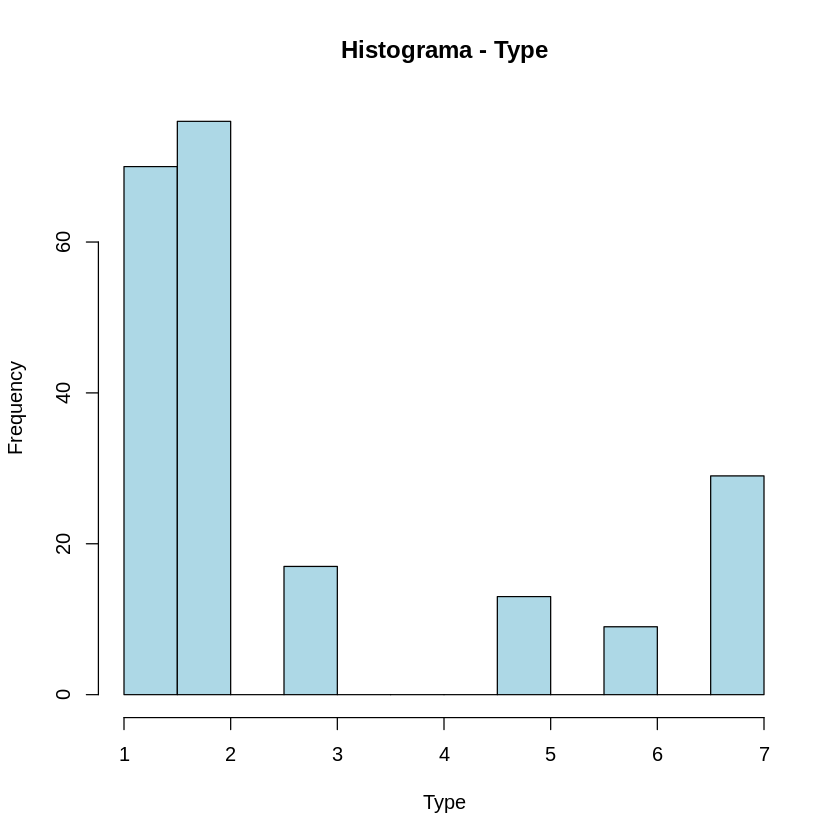

In [ ]:
# Plotar histogramas
par(mfrow = c(1, 1))  # Layout 1X1
for (col in colnames(data)) {
  hist(data[[col]],
       main = paste("Histograma -", col),
       xlab = col,
       col = "lightblue",
       border = "black")
}

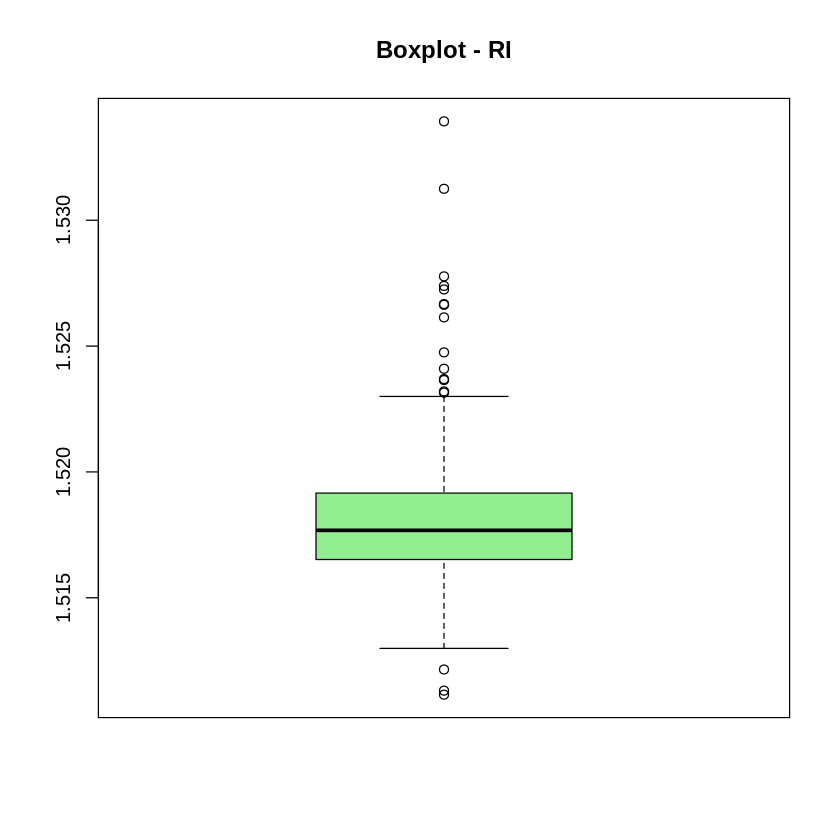

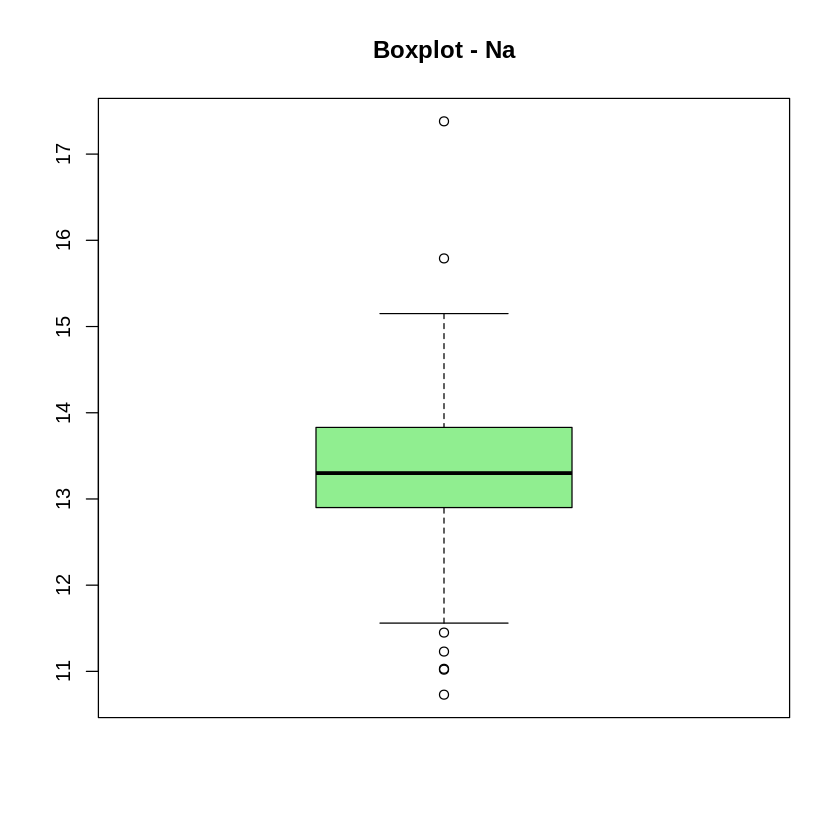

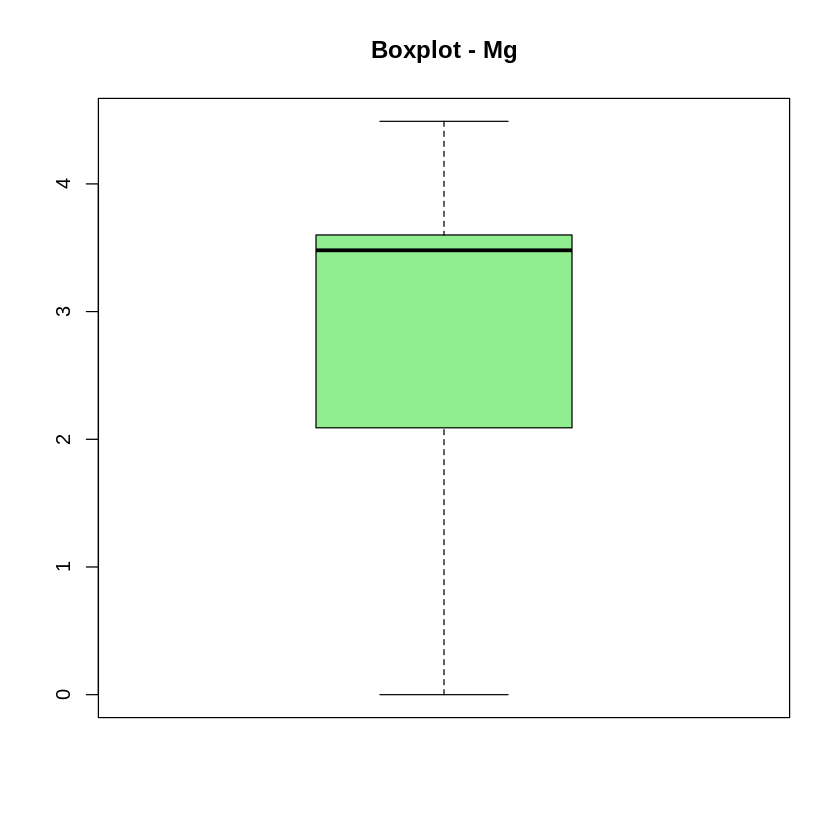

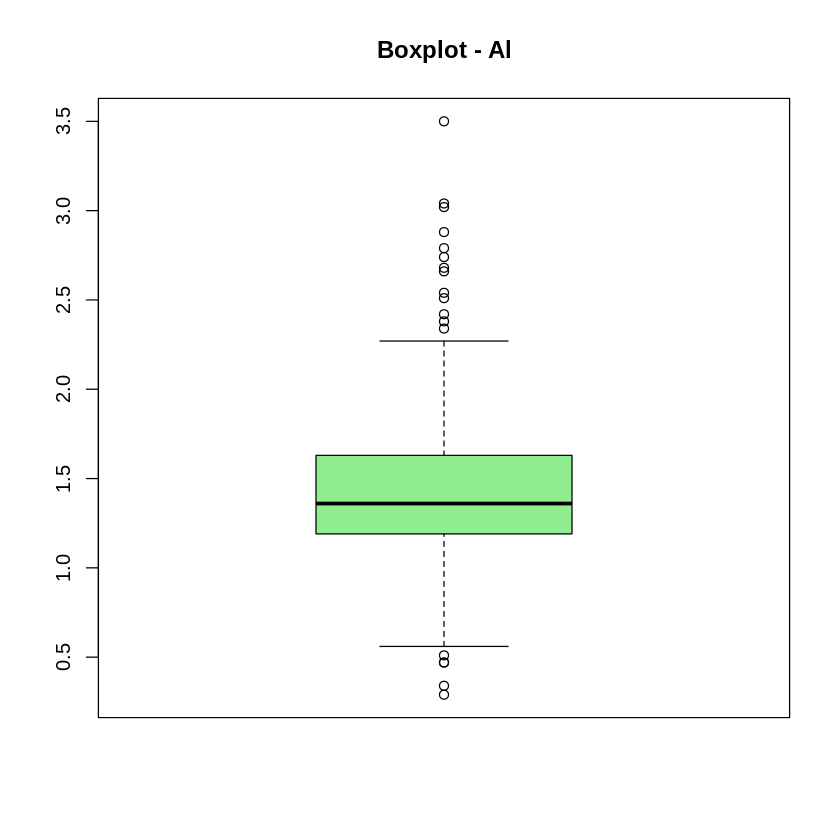

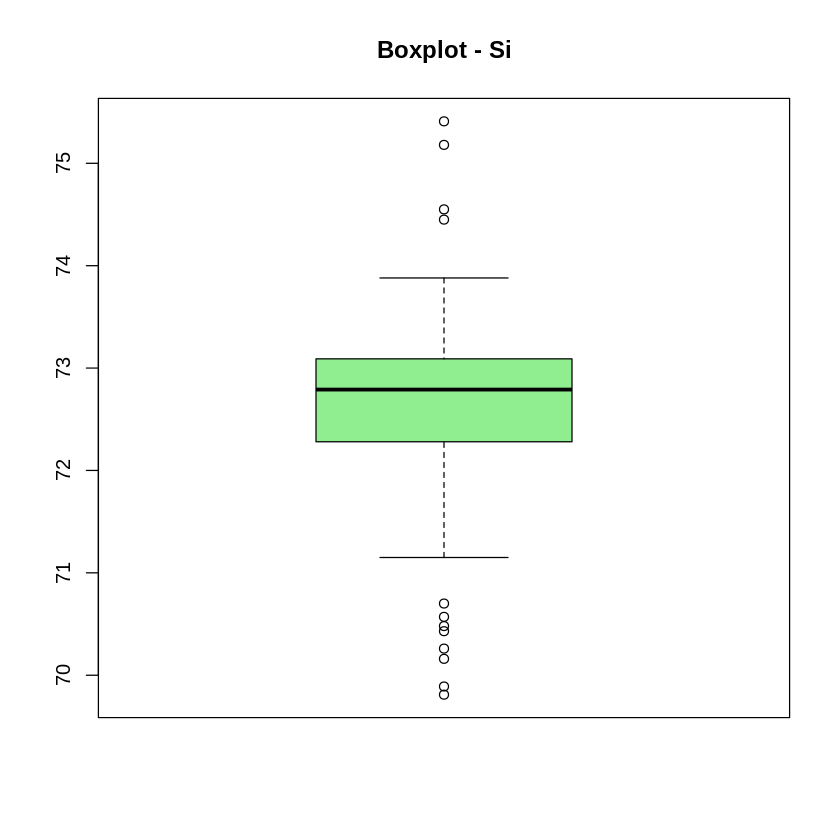

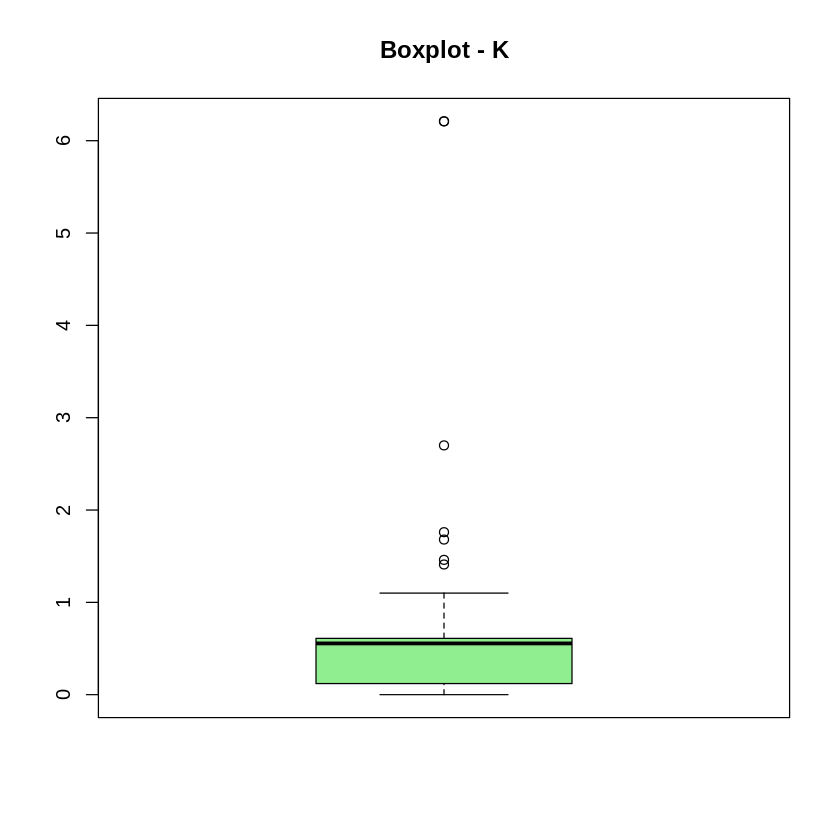

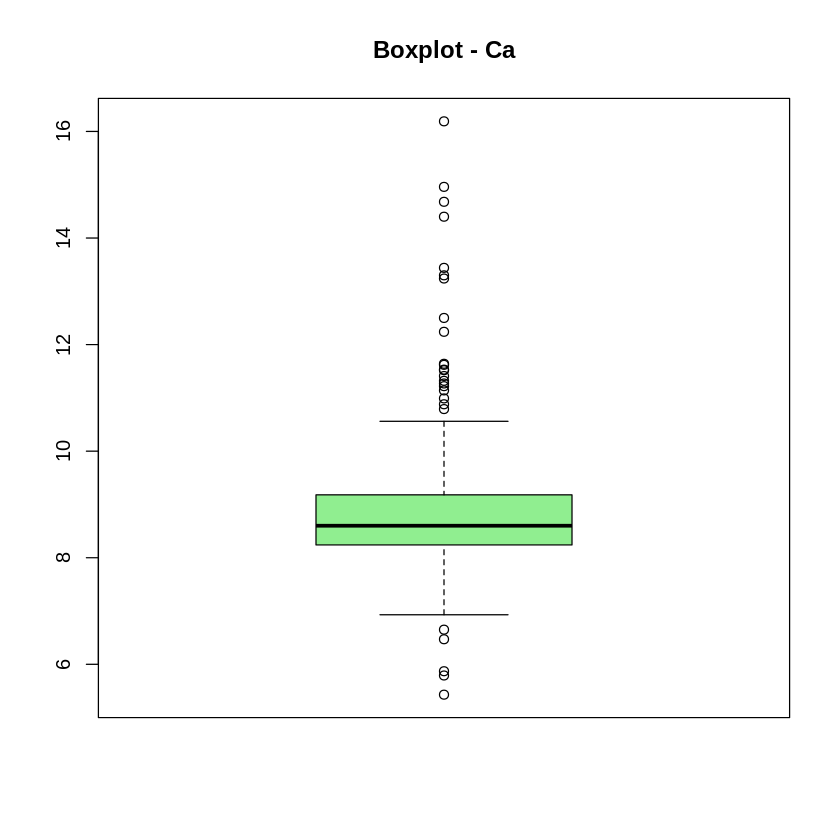

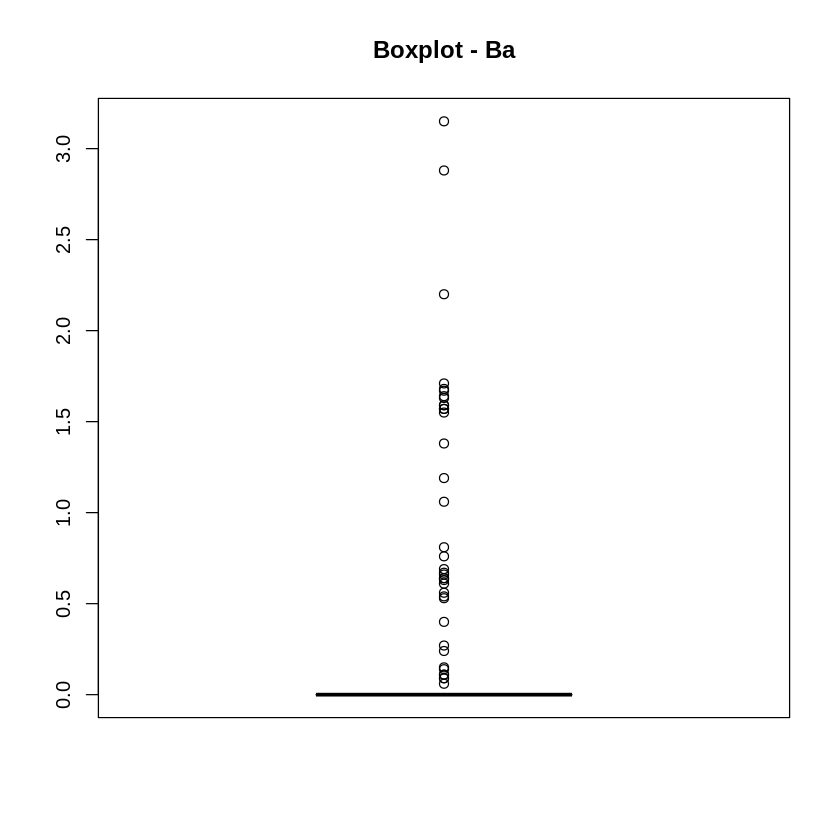

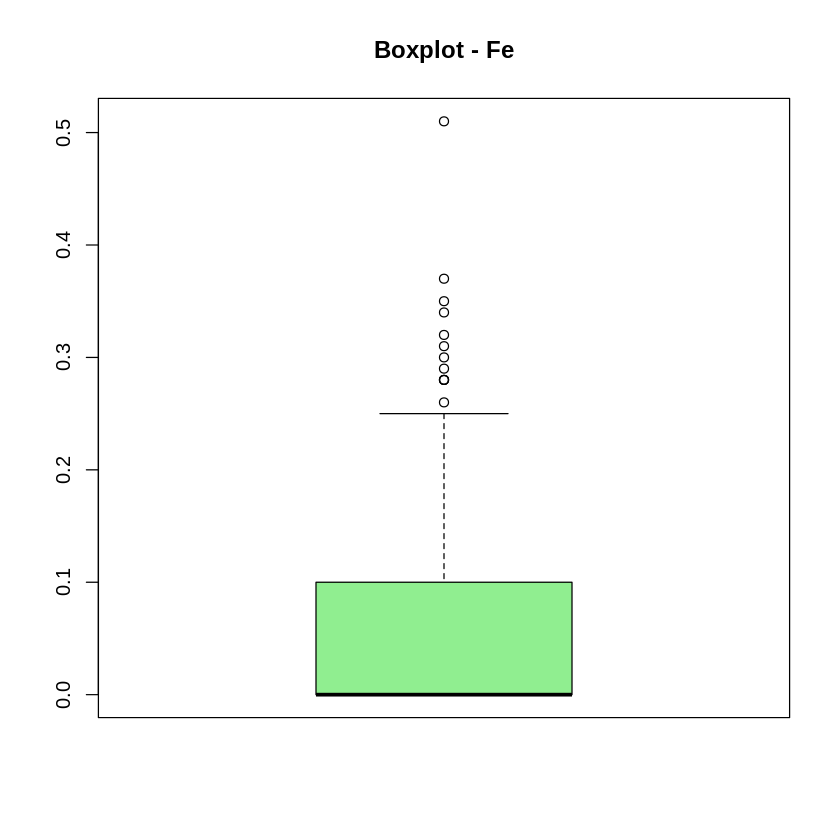

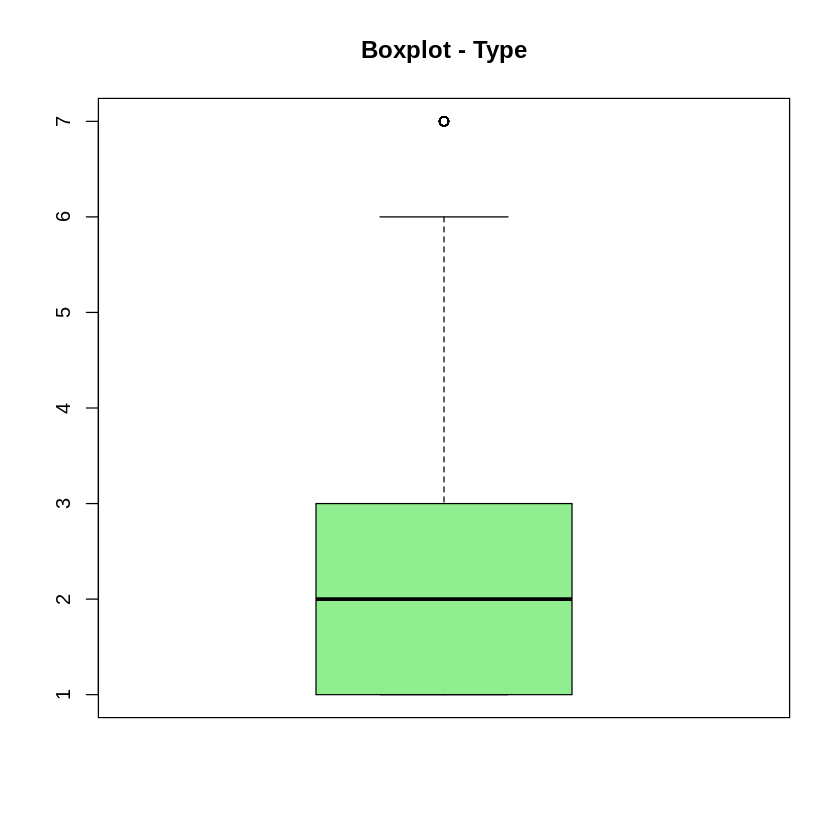

In [ ]:
# Plotar boxplots
par(mfrow = c(1, 1))  # Layout 1X1
for (col in colnames(data)) {
  boxplot(data[[col]],
          main = paste("Boxplot -", col),
          col = "lightgreen",
          horizontal = FALSE)
}
par(mfrow = c(1, 1))

In [ ]:
# Remova colunas não numéricas, como a classe
num_data <- data[, sapply(data, is.numeric)]
num_data$Type <- NULL  # garantir que não está na matriz numérica

# Treinar Isolation Forest (pode ajustar ntree, sample_size e contamination)
iso_model <- isolation.forest(num_data, ntrees = 100, sample_size = 256, ndim=1)

# Obter scores de anomalia (quanto maior, mais anômalo)
anomaly_scores <- predict(iso_model, num_data)

# Definir um limite de corte para outliers (exemplo: top 5% mais anômalos)
threshold <- quantile(anomaly_scores, 0.95)

# Marcar as linhas com scores maiores que o threshold como outliers
outliers <- anomaly_scores > threshold

# Quantidade de linhas antes
n_before <- nrow(data)

# Remover outliers
data_clean <- data[!outliers, ]

# Quantidade de linhas depois
n_after <- nrow(data_clean)

cat("Número de linhas excluídas devido a outliers (Isolation Forest):", n_before - n_after, "\n")

# Mostrar balanceamento das classes antes
cat("Balanceamento de classes antes da remoção de outliers:\n")
print(table(data$Type))

# Mostrar balanceamento das classes depois
cat("Balanceamento de classes após remoção de outliers:\n")
print(table(data_clean$Type))

Warning message in isolation.forest(num_data, ntrees = 100, sample_size = 256, ndim = 1):
“'sample_size' is larger than the number of rows in 'data', will be decreased.”


Número de linhas excluídas devido a outliers (Isolation Forest): 11 
Balanceamento de classes antes da remoção de outliers:

 1  2  3  5  6  7 
70 76 17 13  9 29 
Balanceamento de classes após remoção de outliers:

 1  2  3  5  6  7 
70 73 17  9  8 26 


In [ ]:
# Testes de normalidade multivariada
result_mardia <- mvn(data = data_clean, mvnTest = "mardia")
result_hz <- mvn(data = data_clean, mvnTest = "hz")
result_royston <- mvn(data = data_clean, mvnTest = "royston")

# Teste de normalidade univariada (Shapiro-Wilk para cada variável)
shapiro_tests <- sapply(data_clean, function(var) shapiro.test(var)$p.value)

# ---- Resultados ----
cat("\n🔍 Teste de Normalidade Multivariada: Mardia\n")
print(result_mardia$multivariateNormality)
cat(ifelse(result_mardia$multivariateNormality$Result == "Data follows multivariate normal distribution",
           "✅ Os dados seguem distribuição normal segundo Mardia.\n",
           "❌ Os dados **não** seguem distribuição normal segundo Mardia.\n"))

cat("\n🔍 Teste de Normalidade Multivariada: Henze-Zirkler\n")
print(result_hz$multivariateNormality)
cat(ifelse(result_hz$multivariateNormality$Result == "Data follows multivariate normal distribution",
           "✅ Os dados seguem distribuição normal segundo Henze-Zirkler.\n",
           "❌ Os dados **não** seguem distribuição normal segundo Henze-Zirkler.\n"))

cat("\n🔍 Teste de Normalidade Multivariada: Royston\n")
print(result_royston$multivariateNormality)
cat(ifelse(result_royston$multivariateNormality$Result == "Data follows multivariate normal distribution",
           "✅ Os dados seguem distribuição normal segundo Royston.\n",
           "❌ Os dados **não** seguem distribuição normal segundo Royston.\n"))

cat("\n🔍 Teste de Normalidade Univariada (Shapiro-Wilk):\n")
print(round(shapiro_tests, 4))

# Interpretação do Shapiro-Wilk
non_normal_vars <- names(shapiro_tests[shapiro_tests < 0.05])
if (length(non_normal_vars) == 0) {
  cat("✅ Todas as variáveis passam no teste de normalidade univariada (p > 0.05).\n")
} else {
  cat("❌ As seguintes variáveis **não** seguem distribuição normal (p < 0.05): ",
      paste(non_normal_vars, collapse = ", "), "\n")
}


🔍 Teste de Normalidade Multivariada: Mardia
             Test        Statistic p value Result
1 Mardia Skewness 3087.19634517083       0     NO
2 Mardia Kurtosis 59.4984624648266       0     NO
3             MVN             <NA>    <NA>     NO
❌ Os dados **não** seguem distribuição normal segundo Mardia.
 ❌ Os dados **não** seguem distribuição normal segundo Mardia.
 ❌ Os dados **não** seguem distribuição normal segundo Mardia.

🔍 Teste de Normalidade Multivariada: Henze-Zirkler
           Test       HZ p value MVN
1 Henze-Zirkler 4.373309       0  NO

🔍 Teste de Normalidade Multivariada: Royston
     Test        H      p value MVN
1 Royston 482.3409 6.043685e-99  NO

🔍 Teste de Normalidade Univariada (Shapiro-Wilk):
  RI   Na   Mg   Al   Si    K   Ca   Ba   Fe Type 
   0    0    0    0    0    0    0    0    0    0 
❌ As seguintes variáveis **não** seguem distribuição normal (p < 0.05):  RI, Na, Mg, Al, Si, K, Ca, Ba, Fe, Type 


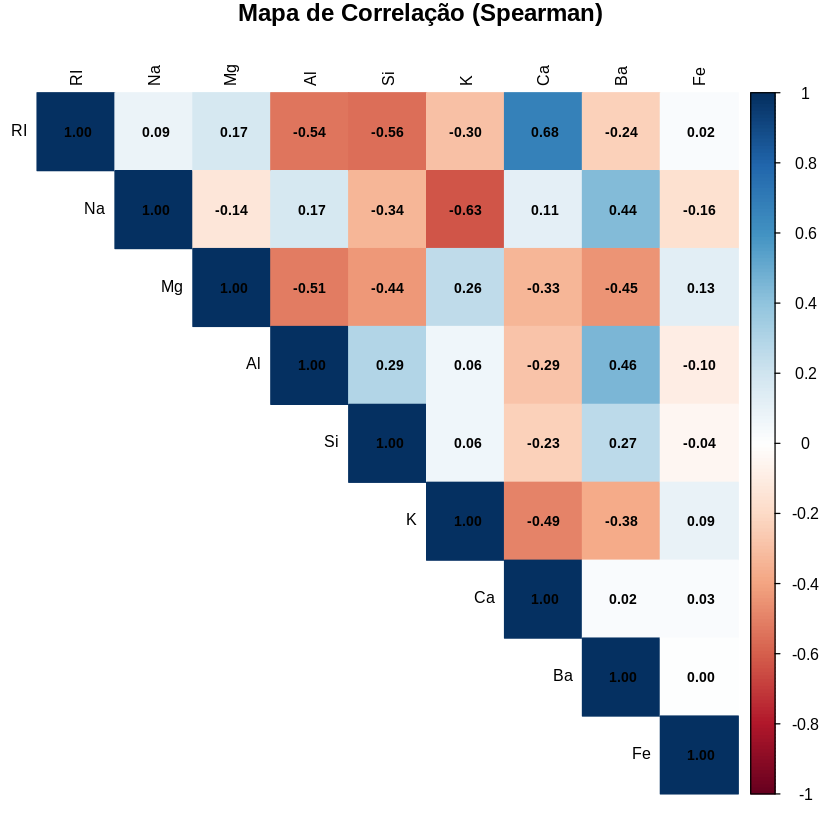

In [ ]:
# Calcular correlação de Spearman
cor_matrix <- cor(data_clean[, -ncol(data_clean)], method = "spearman")

# Mapa de correlação
library(corrplot)
corrplot(cor_matrix, method = "color", type = "upper",
         tl.col = "black", tl.cex = 0.8,
         addCoef.col = "black", number.cex = 0.7,
         title = "Mapa de Correlação (Spearman)", mar = c(0,0,1,0))

In [ ]:
png("scatter_matrix.png", width = 1600, height = 1600, res = 150)
pairs(data_clean[, -ncol(data_clean)], panel = function(x, y) {
  points(x, y, pch = 19, col = rgb(0.1, 0.1, 0.8, 0.3))
  abline(lm(y ~ x), col = "red")
})
dev.off()

pdf 
  2

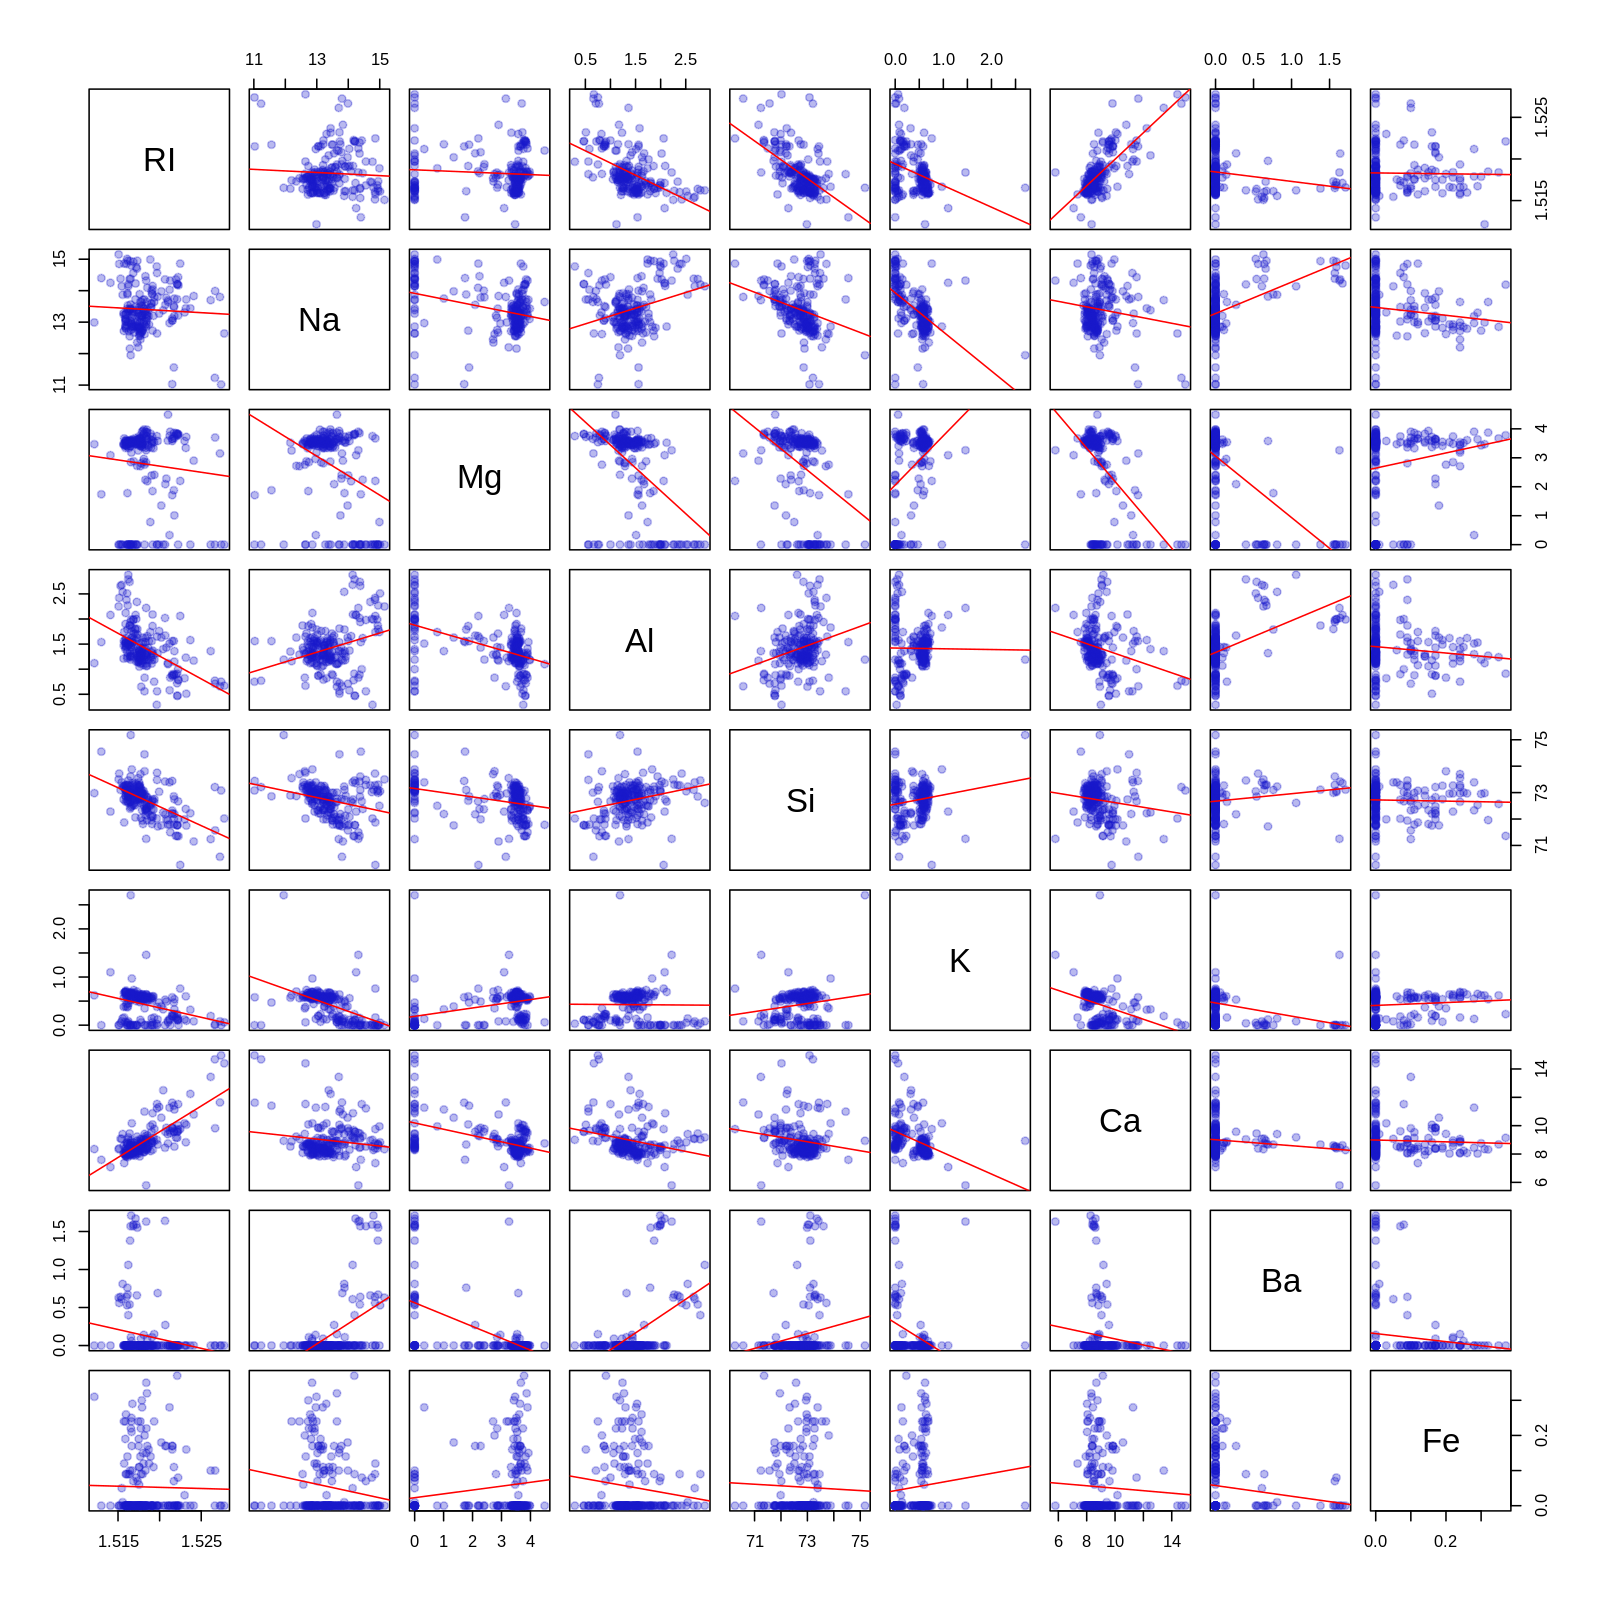

In [ ]:
# --- Normalização Min-Max ---
normalize_minmax <- function(x) {
  return((x - min(x)) / (max(x) - min(x)))
}

data_minmax <- as.data.frame(lapply(data_clean[ , -ncol(data_clean)], normalize_minmax))
data_minmax$Type <- data_clean$Type
cat("Normalização Min-Max concluída.\n")
print(data_minmax)

Normalização Min-Max concluída.
            RI          Na         Mg         Al         Si           K
1   0.56722151 0.634382567 1.00000000 0.31274131 0.30894309 0.022222222
2   0.34955186 0.694915254 0.80178174 0.41312741 0.50203252 0.177777778
3   0.25800256 0.607748184 0.79064588 0.48262548 0.55487805 0.144444444
4   0.35275288 0.530266344 0.82182628 0.38610039 0.47764228 0.211111111
5   0.33738796 0.544794189 0.80623608 0.36679537 0.57317073 0.203703704
6   0.24391805 0.428571429 0.80400891 0.51351351 0.55081301 0.237037037
7   0.33802817 0.552058111 0.80178174 0.32818533 0.57520325 0.214814815
8   0.34635083 0.515738499 0.80400891 0.29343629 0.60569106 0.211111111
9   0.45006402 0.731234867 0.79732739 0.41698842 0.36991870 0.207407407
10  0.34571063 0.479418886 0.80178174 0.41312741 0.55487805 0.211111111
11  0.22791293 0.411622276 0.77060134 0.49034749 0.59756098 0.248148148
12  0.35083227 0.430992736 0.81514477 0.37837838 0.55894309 0.222222222
13  0.23943662 0.450363196 0.763

## RESUMO

- Não linear
- Sem alta correlação entre as variáveis
- Distribuição não segue uma normal

# REDUÇÃO DA DIMENSIONALIDE (DimRED)

2025-05-27 00:40:07.235587: Isomap START

2025-05-27 00:40:07.238858: constructing knn graph

2025-05-27 00:40:07.281111: calculating geodesic distances

2025-05-27 00:40:07.326279: Classical Scaling

Warning message in matchPars(methodObject, list(...)):
“Parameter matching: .control is not a standard parameter, ignoring.”
2025-05-27 00:40:07.880656: Calculating kernel PCA

2025-05-27 00:40:07.934476: Trying to calculate reverse

2025-05-27 00:40:07.952638: DONE



List of 23
 $ python              : chr "/root/.cache/uv/archive-v0/V9xlDMVUlZYfnJwT2htiJ/bin/python3"
 $ libpython           : chr "/root/.local/share/uv/python/cpython-3.11.11-linux-x86_64-gnu/lib/libpython3.11.so"
 $ pythonhome          : chr "/root/.cache/uv/archive-v0/V9xlDMVUlZYfnJwT2htiJ:/root/.cache/uv/archive-v0/V9xlDMVUlZYfnJwT2htiJ"
 $ pythonpath          : chr "/env/python:/root/.local/share/uv/python/cpython-3.11.11-linux-x86_64-gnu/lib/python311.zip:/root/.local/share/"| __truncated__
 $ prefix              : chr "/root/.cache/uv/archive-v0/V9xlDMVUlZYfnJwT2htiJ"
 $ exec_prefix         : chr "/root/.cache/uv/archive-v0/V9xlDMVUlZYfnJwT2htiJ"
 $ base_exec_prefix    : chr "/root/.local/share/uv/python/cpython-3.11.11-linux-x86_64-gnu"
 $ virtualenv          : chr "/root/.cache/uv/archive-v0/V9xlDMVUlZYfnJwT2htiJ"
 $ virtualenv_activate : chr "/root/.cache/uv/archive-v0/V9xlDMVUlZYfnJwT2htiJ/bin/activate_this.py"
 $ executable          : chr "/root/.cache/uv/archive-v0/V9xlD

Erro ao aplicar o método UMAP: Error: Python module umap was not found.

Detected Python configuration:





Erro ao aplicar o método ICA: Error in match.arg(.method): 'arg' should be one of “DiffusionMaps”, “DRR”, “FastICA”, “KamadaKawai”, “DrL”, “FruchtermanReingold”, “HLLE”, “Isomap”, “kPCA”, “PCA_L1”, “MDS”, “nMDS”, “NNMF”, “PCA”, “tSNE”, “UMAP”




Performing eigendecomposition
Computing Diffusion Coordinates
Elapsed time: 0.397 seconds


Warning message in rankmatrix(dX, input = "dist", use):
“0 outside of diagonal in distance matrix”
Warning message in rankmatrix(dX, input = "dist", use):
“0 outside of diagonal in distance matrix”
Warning message in rankmatrix(dX, input = "dist", use):
“0 outside of diagonal in distance matrix”
Warning message in rankmatrix(dX, input = "dist", use):
“0 outside of diagonal in distance matrix”
Warning message in rankmatrix(dX, input = "dist", use):
“0 outside of diagonal in distance matrix”
Warning message in rankmatrix(dX, input = "dist", use):
“0 outside of diagonal in distance matrix”
Warning message in rankmatrix(dX, input = "dist", use):
“0 outside of diagonal in distance matrix”
Warning message in rankmatrix(dX, input = "dist", use):
“0 outside of diagonal in distance matrix”
Warning message in rankmatrix(dX, input = "dist", use):
“0 outside of diagonal in distance matrix”
Warning message in rankmatrix(dX, input = "dist", use):
“0 outside of diagonal in distance matrix”
Warning me

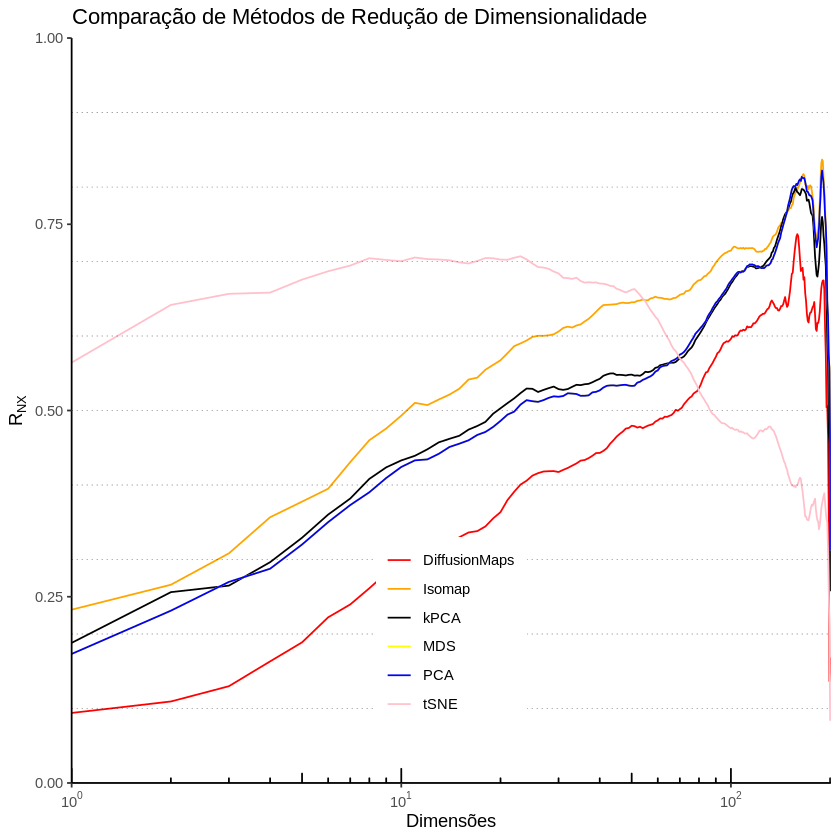

In [ ]:
#OK - METODO DE REDUÇÃO DE DIMENSIONALIDADE
# Dados: excluir coluna de classe e converter para dimRedData
data_minmax_vars <- data_minmax[, -ncol(data_minmax)]
data_dr <- dimRedData(data_minmax_vars)
classe <- as.factor(data_clean[, ncol(data_clean)])

# Definir métodos de redução de dimensionalidade válidos para `dimRed`
embed_methods <- c("PCA", "Isomap", "tSNE", "kPCA", "MDS", "UMAP", "ICA", "DiffusionMaps")

# Configuração específica de `ndim` para kPCA
kPCA_control <- list(ndim = 5)  # Ajuste o número de dimensões de saída conforme necessário

# Aplicar métodos de redução de dimensionalidade sem passar `method` como parâmetro
data_emb <- lapply(embed_methods, function(method) {
  tryCatch(
    {
      # Verificar se o método requer pacotes específicos (tSNE e UMAP)
      if (method == "tSNE" && !requireNamespace("Rtsne", quietly = TRUE)) {
        stop("Pacote 'Rtsne' não encontrado. Instale com install.packages('Rtsne')")
      }
      if (method == "UMAP" && !requireNamespace("umap", quietly = TRUE)) {
        stop("Pacote 'umap' não encontrado. Instale com install.packages('umap')")
      }
      if (method == "Isomap" && !requireNamespace("RANN", quietly = TRUE)) {
        stop("Pacote 'RANN' não encontrado. Instale com install.packages('RANN')")
      }
      if (method == "DiffusionMaps" && !requireNamespace("diffusionMap", quietly = TRUE)) {
        stop("Pacote 'diffusionMap' não encontrado. Instale com install.packages('diffusionMap')")
      }
      # Aplicar o método de redução de dimensionalidade
      #emb <- dimRed::embed(data_dr[,1:8], .method = method)  # Passar o método diretamente como string
            if (method == "kPCA") {
        emb <- dimRed::embed(data_dr[,1:8], .method = method, .control = kPCA_control)
      } else {
        emb <- dimRed::embed(data_dr[,1:8], .method = method)
      }

      if (!is.null(emb)) emb else NULL  # Filtrar métodos que falharam
    },
    error = function(e) {
      message("Erro ao aplicar o método ", method, ": ", e)
      NULL
    }
  )
})
names(data_emb) <- embed_methods
data_emb <- Filter(Negate(is.null), data_emb)  # Remover métodos com falhas

# Plotar as curvas R_NX para métodos válidos
if (length(data_emb) > 0) {
  plot <- dimRed::plot_R_NX(data_emb) +
    ggplot2::theme(
      legend.title = ggplot2::element_blank(),
      legend.position = c(0.5, 0.1),
      legend.justification = c(0.5, 0.1)
    ) +
    ggplot2::labs(
      title = "Comparação de Métodos de Redução de Dimensionalidade",
      x = "Dimensões",
      y = "Curva R_NX"
    ) +
      # Alterar cor da curva do método Isomap
    ggplot2::scale_color_manual(
      values = c("Isomap" = "orange", # Altere para "black" se desejar
                 "PCA" = "blue",
                 "FastICA" = "green",
                 "tSNE" = "pink",
                 "DiffusionMaps" = "red",
                 "MDS"="yellow",
                 "kPCA"="black") # Changed #black to "black"

    )
  print(plot)
} else {
  message("Nenhum método de redução de dimensionalidade pôde ser aplicado.")
}


In [ ]:
# Salvar a figura maior após criá-la
ggsave("dimred_comparacao.png", plot = plot, width = 12, height = 8, dpi = 300)

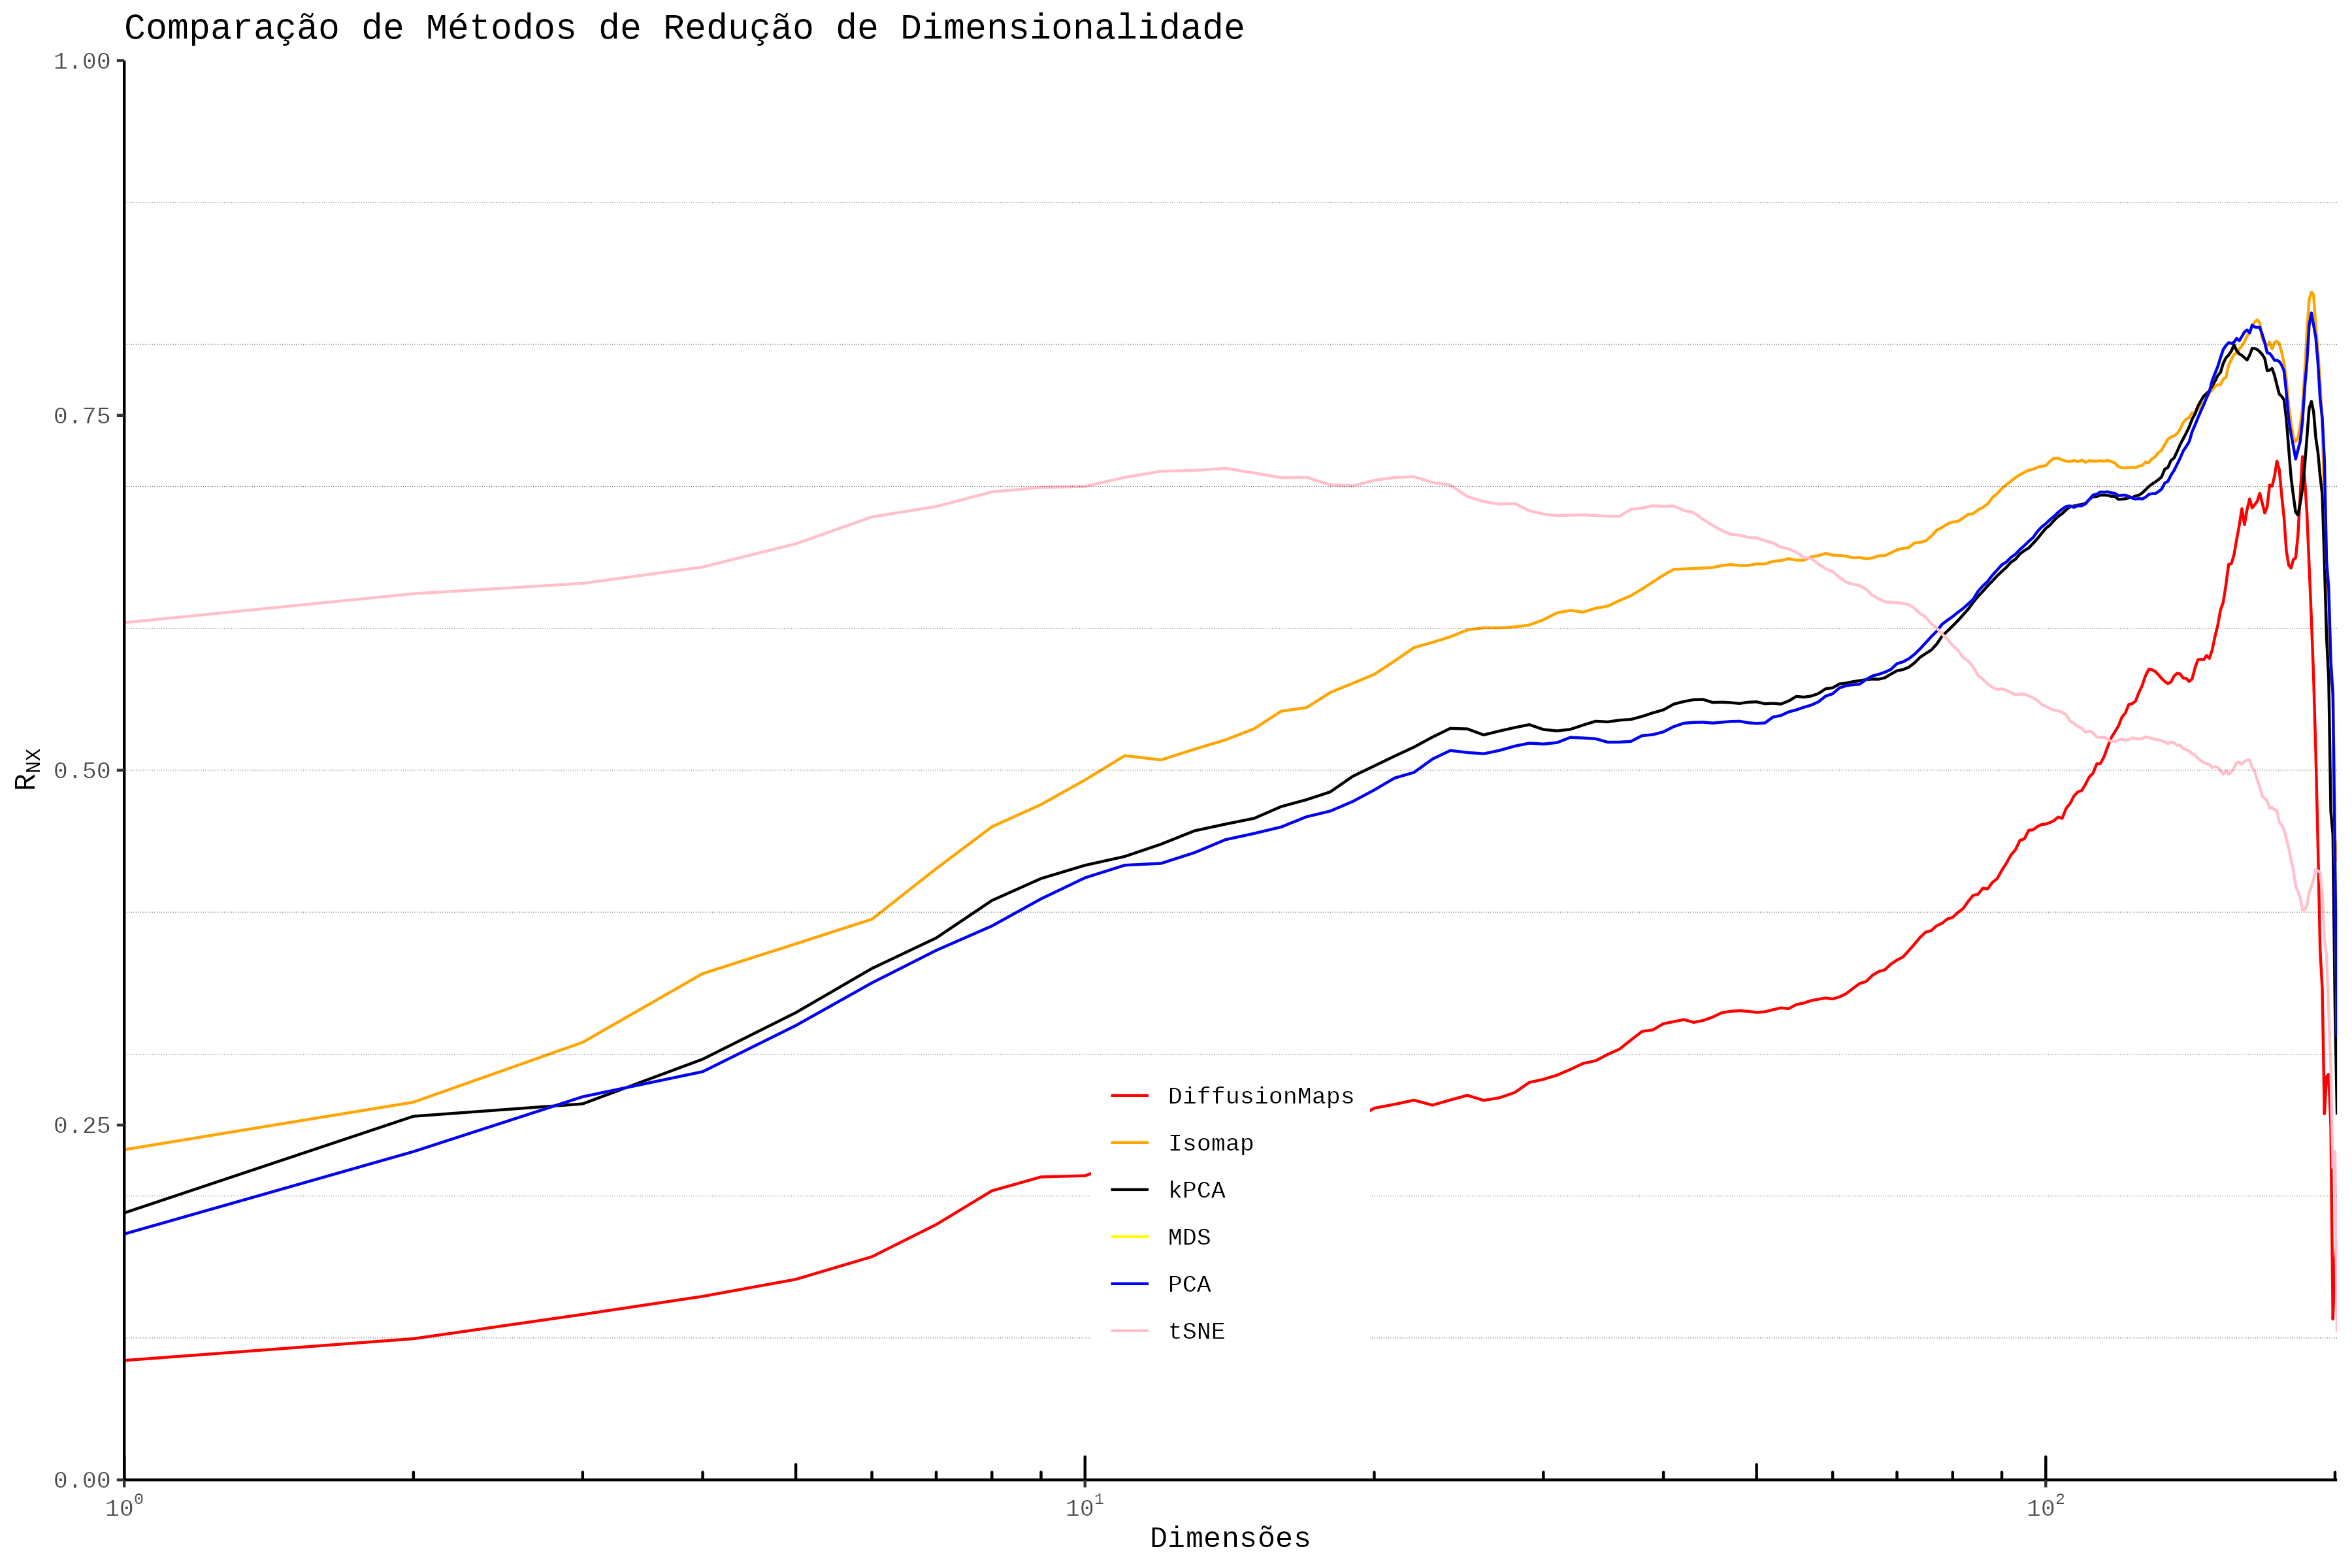

In [ ]:
auc_results <- sapply(data_emb, function(emb) {
  rnx <- dimRed::R_NX(emb)  # extrai o vetor R_NX para o embedding

  dims <- seq_along(rnx)  # eixo x é o número da dimensão

  # Regra do trapézio para área sob a curva
  sum(diff(dims) * (head(rnx, -1) + tail(rnx, -1)) / 2)
})

# Ordenar do maior para o menor (melhor método no topo)
auc_sorted <- sort(auc_results, decreasing = TRUE)

print(auc_sorted)

Warning message in rankmatrix(dX, input = "dist", use):
“0 outside of diagonal in distance matrix”
Warning message in rankmatrix(dX, input = "dist", use):
“0 outside of diagonal in distance matrix”
Warning message in rankmatrix(dX, input = "dist", use):
“0 outside of diagonal in distance matrix”
Warning message in rankmatrix(dX, input = "dist", use):
“0 outside of diagonal in distance matrix”
Warning message in rankmatrix(dX, input = "dist", use):
“0 outside of diagonal in distance matrix”
Warning message in rankmatrix(dX, input = "dist", use):
“0 outside of diagonal in distance matrix”
Warning message in rankmatrix(dX, input = "dist", use):
“0 outside of diagonal in distance matrix”
Warning message in rankmatrix(dX, input = "dist", use):
“0 outside of diagonal in distance matrix”
Warning message in rankmatrix(dX, input = "dist", use):
“0 outside of diagonal in distance matrix”
Warning message in rankmatrix(dX, input = "dist", use):
“0 outside of diagonal in distance matrix”
Warning me

       Isomap           PCA           MDS          kPCA DiffusionMaps 
     136.0783      126.9552      126.9552      125.9705      107.2490 
         tSNE 
     102.8121 


# Utilizando o ISOMAP

Maior área abaixo da curva

In [ ]:
# Aplicar Isomap com número de dimensões desejadas
isomap_result <- dimRed::embed(data_dr, .method = "Isomap", .control = list(ndim = 2))  # Altere ndim se quiser mais dimensões

# Verificar o tipo de objeto retornado
print(class(isomap_result))

# Exibir a estrutura do objeto retornado
print(str(isomap_result))

In [ ]:
# Aplicar Isomap com número de dimensões desejadas
isomap_result <- dimRed::embed(data_dr, .method = "Isomap", .control = list(ndim = 2))  # Altere ndim se quiser mais dimensões

# Extrair os dados transformados diretamente do objeto dimRedResult
reduced_data <- as.data.frame(isomap_result@data)

# Verificar resultado
head(reduced_data)

In [ ]:
# Adicionar a coluna da classe (se ainda não fez isso)
reduced_data$classe <- classe

# Plotar as dimensões reduzidas
ggplot(reduced_data, aes(x = iso.1, y = iso.2, color = classe)) +
  geom_point(alpha = 0.7, size = 3) +
  labs(
    title = "Representação Bidimensional com Isomap",
    x = "Componente Isomap 1",
    y = "Componente Isomap 2",
    color = "Classe"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
    axis.title = element_text(size = 14),
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 10)
  )